In [2]:
import Data_loader_module 
import Build_model
from transformers import DetrImageProcessor, DetrForObjectDetection
import matplotlib.pyplot as plt
import os
import supervision as sv 
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
import torch
from pytorch_lightning import Trainer

# Prepare dataset

In [7]:
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIR = "train"
VAL_DIR = "valid"
TEST_DIR = "test"

image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [13]:
TRAIN_DATASET = Data_loader_module.CocoDetection(image_dir=TRAIN_DIR, image_processor=image_processor, train=True)
VAL_DATASET = Data_loader_module.CocoDetection(image_dir=VAL_DIR, image_processor=image_processor, train=False)
TEST_DATASET = Data_loader_module.CocoDetection(image_dir=TEST_DIR, image_processor=image_processor, train=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Explore dataset

In [4]:
print(len(TRAIN_DATASET))
print(len(VAL_DATASET))
print(len(TEST_DATASET))

326
88
44


In [5]:
TRAIN_DATASET

Dataset CocoDetection
    Number of datapoints: 326
    Root location: train

In [6]:
image_ids = TRAIN_DATASET.coco.getImgIds()

In [7]:
image_ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [8]:
image = TRAIN_DATASET.coco.loadImgs([0])[0]

In [9]:
image

{'id': 0,
 'license': 1,
 'file_name': '70_jpg.rf.a45b1f9b3f335f0cc7210b9dc2f858cf.jpg',
 'height': 1024,
 'width': 752,
 'date_captured': '2022-08-30T09:40:29+00:00'}

In [10]:
annotations = TRAIN_DATASET.coco.imgToAnns[0]
annotations

[{'id': 0,
  'image_id': 0,
  'category_id': 4,
  'bbox': [242, 211, 125, 175],
  'area': 21875,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 0,
  'category_id': 4,
  'bbox': [297, 502, 144, 147],
  'area': 21168,
  'segmentation': [],
  'iscrowd': 0}]

(np.float64(-0.5), np.float64(751.5), np.float64(1023.5), np.float64(-0.5))

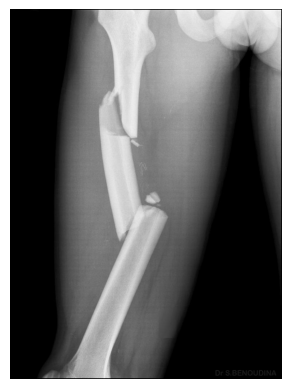

In [11]:
image_path = os.path.join(TRAIN_DIR, image['file_name'])
real_image = Image.open(image_path)
plt.imshow(real_image)
plt.axis("off")

In [12]:
def coco_to_detections(annotations):
    """Convert COCO annotations to supervision detections."""
    xyxy = np.array([[x, y, x + w, y + h] for ann in annotations for x, y, w, h in [ann["bbox"]]])
    class_id = np.array([ann["category_id"] for ann in annotations])
    return sv.Detections(xyxy=xyxy, class_id=class_id)


In [13]:
detections = coco_to_detections(annotations)

In [14]:
detections

Detections(xyxy=array([[242, 211, 367, 386],
       [297, 502, 441, 649]]), mask=None, confidence=None, class_id=array([4, 4]), tracker_id=None, data={}, metadata={})

In [14]:
categories = TRAIN_DATASET.coco.cats
categories

{0: {'id': 0, 'name': 'bone-fracture', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'angle', 'supercategory': 'bone-fracture'},
 2: {'id': 2, 'name': 'fracture', 'supercategory': 'bone-fracture'},
 3: {'id': 3, 'name': 'line', 'supercategory': 'bone-fracture'},
 4: {'id': 4, 'name': 'messed_up_angle', 'supercategory': 'bone-fracture'}}

In [15]:
id2label = {k : v['name'] for k, v in categories.items()}
id2label

{0: 'bone-fracture',
 1: 'angle',
 2: 'fracture',
 3: 'line',
 4: 'messed_up_angle'}

In [17]:
type(detections)

supervision.detection.core.Detections

In [18]:
detections.class_id

array([4, 4])

In [19]:
labels = [id2label[class_id] for class_id in detections.class_id]
labels

['messed_up_angle', 'messed_up_angle']

In [20]:
box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=real_image, detections=detections,)

label_annotator = sv.LabelAnnotator()
frame = label_annotator.annotate(scene=real_image, detections=detections, labels=labels)


(np.float64(-0.5), np.float64(751.5), np.float64(1023.5), np.float64(-0.5))

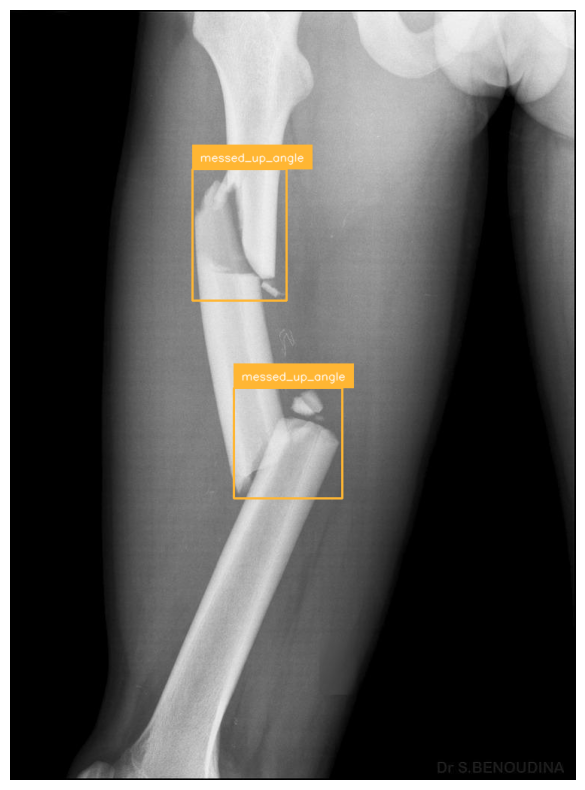

In [21]:
plt.figure(figsize=(16, 10))
plt.imshow(frame)
plt.axis("off")

# Fine-tune model

In [22]:
torch.set_float32_matmul_precision("medium")

In [ ]:
# To preprocess input before passing it to the model
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    encoding = image_processor.pad(pixel_values, return_tensors="pt")


    return {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding["pixel_mask"],
        "labels": labels
    }

In [24]:
TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET,
                              collate_fn=collate_fn, 
                              batch_size=4,
                              shuffle=True)

VAL_DATALOADER = DataLoader(dataset=VAL_DATASET,
                            collate_fn=collate_fn, 
                            batch_size=4,
                            shuffle=False)

In [25]:
model = Build_model.DeTr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, idslabel=id2label, TRAIN_DATALOADER=TRAIN_DATALOADER, VAL_DATALOADER=VAL_DATALOADER)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [26]:
log_dir = "log"
MAX_EPOCHS = 200
trainer = Trainer(devices=1,
                  accelerator="gpu",
                  gradient_clip_val=0.1,
                  accumulate_grad_batches=8,
                  log_every_n_steps=1, 
                  max_epochs=MAX_EPOCHS, 
                  default_root_dir=log_dir)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [27]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode | FLOPs
----------------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval | 0    
----------------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.011   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [28]:
model.model.save_pretrained("DETR_finetune_model")

# Test model

In [3]:
model = DetrForObjectDetection.from_pretrained("DETR_finetune_model")
model.to("cuda")

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [4]:
box_annotator = sv.BoxAnnotator()

(np.float64(-0.5), np.float64(905.5), np.float64(1023.5), np.float64(-0.5))

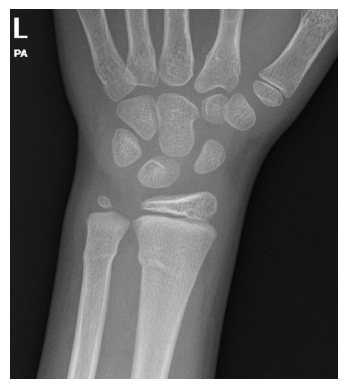

In [6]:
image_path = "test/16_jpg.rf.0ef960d157f3f332421d9d5a8248a00f.jpg"
real_test_image = Image.open(image_path)
plt.imshow(real_test_image)
plt.axis("off")

In [9]:
CONFIDENCE_THRESHOLD = 0.35

with torch.no_grad():
    inputs = image_processor(images=real_test_image, return_tensors="pt").to("cuda")
    output = model(**inputs)
    target_sizes = torch.tensor([[real_test_image.height, real_test_image.width]]).to("cuda")
    results = image_processor.post_process_object_detection(outputs=output, threshold=CONFIDENCE_THRESHOLD, target_sizes=target_sizes)[0]

In [10]:
output

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-3.6461, -1.7546, -4.7417, -3.0866, -3.8213,  7.8617],
         [-4.2455, -2.1554, -3.4313, -3.7019, -4.0466,  7.7604],
         [-3.8601, -1.6970, -4.2966, -2.9762, -3.9683,  7.7857],
         [-4.4438, -2.0531, -2.9930, -3.3907, -4.2743,  7.4963],
         [-4.1007, -2.3830, -3.3932, -3.8621, -3.9704,  7.7736],
         [-4.1944, -1.5445, -4.5590, -2.7156, -3.8026,  7.6452],
         [-4.5024, -0.5832, -2.8656, -1.9390, -4.0059,  6.4310],
         [-4.0680, -1.4740, -4.4790, -2.5985, -3.7668,  7.4177],
         [-3.9195, -2.4313, -3.6036, -3.9794, -3.9444,  7.8406],
         [-3.9367, -2.5135, -3.7773, -4.1315, -3.7222,  7.9998],
         [-4.0043, -1.4726, -4.6045, -2.9795, -3.7851,  7.6951],
         [-3.7679, -1.7042, -4.4652, -2.8644, -4.0503,  7.7962],
         [-3.6959, -2.2104, -3.6552, -3.4299, -4.2584,  7.6762],
         [-3.7135, -2.2482, -3.5561, -3.4394, -4.3115,  7.6615],
         [-3.1745,  0.8695,  1

In [11]:
results

{'scores': tensor([0.7564, 0.6874], device='cuda:0'),
 'labels': tensor([3, 3], device='cuda:0'),
 'boxes': tensor([[352.7925, 681.2238, 458.9873, 740.9454],
         [356.2167, 681.1804, 452.1001, 732.5927]], device='cuda:0')}

In [26]:
test_detections = sv.Detections.from_transformers(transformers_results=results)

In [27]:
test_detections

Detections(xyxy=array([[352.7925 , 681.22375, 458.98727, 740.94543],
       [356.21667, 681.18036, 452.10013, 732.5927 ]], dtype=float32), mask=None, confidence=array([0.75636536, 0.6873855 ], dtype=float32), class_id=array([3, 3]), tracker_id=None, data={}, metadata={})

In [18]:
id2label

{0: 'bone-fracture',
 1: 'angle',
 2: 'fracture',
 3: 'line',
 4: 'messed_up_angle'}

In [28]:
test_labels = [f"{id2label[class_id]} {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]
test_labels

['line 0.76', 'line 0.69']

In [29]:
test_frame = box_annotator.annotate(scene=real_test_image, detections=test_detections)

label_annotator = sv.LabelAnnotator()
test_frame = label_annotator.annotate(scene=real_test_image, detections=test_detections, labels=test_labels)

(np.float64(-0.5), np.float64(905.5), np.float64(1023.5), np.float64(-0.5))

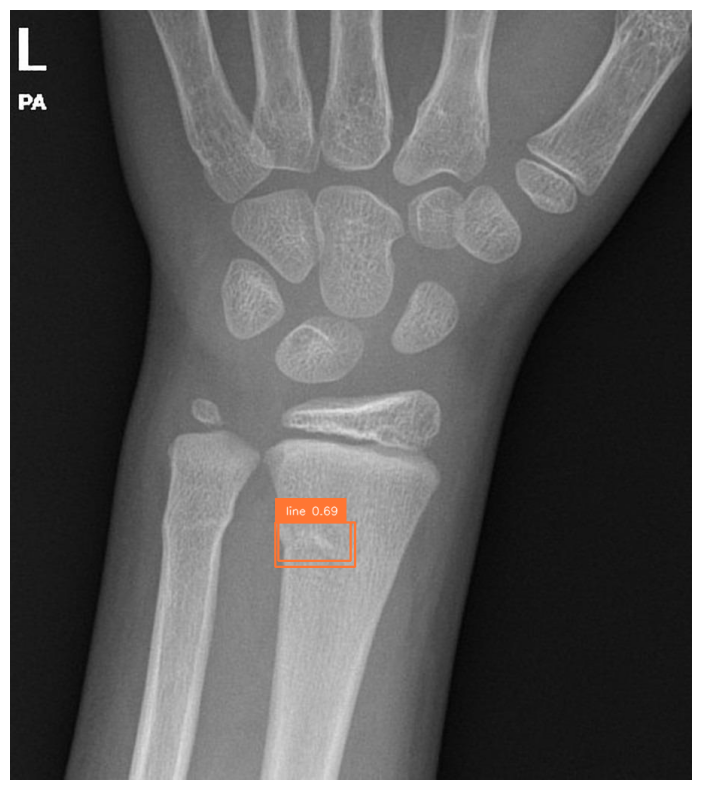

In [30]:
plt.figure(figsize=(16, 10))
plt.imshow(test_frame)
plt.axis("off")